In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import math
from sklearn import svm,  linear_model
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# Read csv to list
with open('bank-full.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    content = []
    for row in reader:
        content.append(row)
attributes = content[0]
content = content[1:]
print 'Attributes:', attributes
print 'Number of data', len(content)

Attributes: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
Number of data 45211


In [5]:
len([x for x in content if x[16] == 'yes' ])

5289

In [6]:
# Encode data
data = []
for row in content:
    thisData = {}
    for i, att in enumerate(row):
        if attributes[i] in set(['age','balance','day','duration','campaign','pdays','previous']):
            thisData[attributes[i]] = int(att)
        elif attributes[i] == 'month': # jan to dec
             thisData[attributes[i]] = att
        elif attributes[i] in ['default', 'housing', 'loan', 'y']: #['yes', 'no']
            thisData[attributes[i]] = 1 if att == 'yes' else 0
        elif attributes[i] == 'job': #['management', 'retired', 'self-employed', 'unknown', 'unemployed', 'housemaid', 'admin.', 'entrepreneur', 'services', 'student', 'technician', 'blue-collar']
            thisData[attributes[i]] = att
        elif attributes[i] == 'marital': #['single', 'married', 'divorced']
            thisData[attributes[i]] = att
        elif attributes[i] == 'education': #['unknown', 'primary', 'tertiary', 'secondary']
            thisData[attributes[i]] = att 
        elif attributes[i] == 'contact':# ['unknown', 'telephone', 'cellular']
            thisData[attributes[i]] = att
        elif attributes[i] == 'poutcome': #['unknown', 'other', 'success', 'failure']
            thisData[attributes[i]] = att
        else:
            print 'error'
    data.append(thisData)

In [7]:
# Split data to 6:2:2
np.random.seed(0)
np.random.shuffle(data)
trainingData = data[:int(len(data)*0.6)]
validationData = data[int(len(data)*0.6):int(len(data)*0.8)]
testData = data[int(len(data)*0.8):]

In [8]:
len([x for x in trainingData if x['y'] == 1 ]) * 1. / len(trainingData)

0.11597729115977291

In [9]:
len([x for x in content if x[16] == 'yes' ])

5289

In [10]:
educationDic = {'unknown':0, 'primary':1, 'secondary':2, 'tertiary':3}
def encodeEducation(education):
    feat = [0]*4
    feat[educationDic[education]] = 1
    return feat

In [11]:
maritalDic = {'single':0, 'married':1, 'divorced':2}
def encodeMarital(marital):
    feat = [0]*3
    feat[maritalDic[marital]] = 1
    return feat

In [12]:
jobs = list(set([d['job'] for d in data]))
jobDic = {j:i for i,j in enumerate(jobs)}
def encodeJob(job):
    feat = [0]*len(jobs)
    feat[jobDic[job]] = 1
    return feat

In [13]:
contactDic = {'unknown':0, 'telephone':1, 'cellular':2}
def encodeContact(contact):
    feat = [0] * 3
    feat[contactDic[contact]] = 1
    return feat
#     return [1] if contact == 'unknown' else [0]

In [14]:
import calendar
monthDic = {v.lower(): k for k,v in enumerate(calendar.month_abbr)}
def encodeMonth(month):
    feat = [0] * 13
    feat[monthDic[month]] = 1
    return feat

In [15]:
outcomeDic = {'unknown':0, 'other':1, 'failure':2, 'success':3}
def encodeOutcome(outcome):
    feat = [0] * 4
    feat[outcomeDic[outcome]] = 1
    return feat

In [16]:
def encodeAge(age):
    if age <= 25 or age >= 60:
        return [1]
    else:
        return [0]

In [17]:
def generateFeature_Forest(dataset):
    features = []
    for data in dataset:        
        feat = [data['age'], data['duration'], data['previous'], data['pdays'], data['campaign'], \
                data['housing'] + data['loan'] + data['default']]\
        + encodeMonth(data['month']) + encodeOutcome(data['poutcome']) \
        + encodeContact(data['contact'])

        features.append(feat)
    return features
def generateFeature(dataset):
    features = []
    for data in dataset:        
        feat = [data['age'], data['duration'], data['previous'], data['pdays'], data['campaign']]\
        + encodeMonth(data['month']) + encodeOutcome(data['poutcome']) \

        features.append(feat)
    return features

In [18]:
cwList = []
trainList = []
validList = []
def errorRate(pred, label):
    truePositives = len(filter(lambda x: x[0] == x[1] == True, zip(pred, label)))
    trueNegatives = len(filter(lambda x: x[0] == x[1] == False, zip(pred, label)))
    falsePositives = len(filter(lambda x: x[0] == True and x[1] == False, zip(pred, label)))
    falseNegatives = len(filter(lambda x: x[0] == False and x[1] == True, zip(pred, label)))
    truePositiveRate = truePositives * 1. / (truePositives + falseNegatives)
    trueNegativeRate = trueNegatives * 1. / (trueNegatives + falsePositives)
    balanceErrorRate = 1 - 0.5 * (truePositiveRate + trueNegativeRate)
    print "True Positives:", truePositives
    print "True Negatives:", trueNegatives
    print "False Positives:", falsePositives
    print "False Negatives:", falseNegatives
    print "True Positive Rate:", truePositiveRate
    print "True Negative Rate:", trueNegativeRate
    print "Balanced Error Rate:", balanceErrorRate
    return truePositives, trueNegatives, falsePositives, falseNegatives, truePositiveRate, trueNegativeRate, balanceErrorRate

In [19]:
X_train = generateFeature(trainingData)
y_train = [d['y'] for d in trainingData]
X_validation = generateFeature(validationData)
y_validation = [d['y'] for d in validationData]
X_test = generateFeature(testData)
y_test = [d['y'] for d in testData]

In [20]:
# Linear
linear = linear_model.SGDClassifier()
linear.fit(X_train, y_train)
validationPredict = linear.predict(X_validation)
print errorRate(validationPredict, y_validation)

True Positives: 1
True Negatives: 7967
False Positives: 5
False Negatives: 1069
True Positive Rate: 0.000934579439252
True Negative Rate: 0.999372804817
Balanced Error Rate: 0.499846307872
(1, 7967, 5, 1069, 0.0009345794392523365, 0.999372804816859, 0.4998463078719444)


In [73]:
# Support vector classification
clf = svm.SVC(C=0.1, class_weight = {0:1, 1:5})
clf.fit(X_train, y_train)
trainingPredict = clf.predict(X_train)
validationPredict = clf.predict(X_validation)
print errorRate(validationPredict, y_validation)

True Positives: 824
True Negatives: 5767
False Positives: 2205
False Negatives: 246
True Positive Rate: 0.770093457944
True Negative Rate: 0.723406924235
Balanced Error Rate: 0.253249808911
(824, 5767, 2205, 246, 0.7700934579439253, 0.7234069242348219, 0.25324980891062643)


In [ ]:
clf.

In [21]:
# Random Forest Classifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_forest = generateFeature_Forest(trainingData)
y_train_forest = [d['y'] for d in trainingData]
X_validation_forest = generateFeature_Forest(validationData)

y_validation_forest = [d['y'] for d in validationData]
X_test_forest = generateFeature_Forest(testData)
y_test_forest = [d['y'] for d in testData]

tree = RandomForestClassifier(n_estimators= 40, max_depth= 10, max_features='log2', bootstrap=True, random_state=0,\
                              class_weight='balanced')
tree.fit(X_train_forest, y_train_forest)
trainingPredict = tree.predict(X_train_forest)
validationPredict = tree.predict(X_validation_forest)
print errorRate(validationPredict, y_validation_forest)

True Positives: 916
True Negatives: 6713
False Positives: 1259
False Negatives: 154
True Positive Rate: 0.856074766355
True Negative Rate: 0.842072252885
Balanced Error Rate: 0.15092649038
(916, 6713, 1259, 154, 0.8560747663551402, 0.8420722528850978, 0.15092649037988104)


In [37]:
print len(X_train_forest[0])

26


In [28]:
months = [calendar.month_abbr[i] for i in range(1,13)]
months

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

In [72]:
feat = list(['age', 'duration', 'previous', 'pdays', 'campaign', 'housing', 'loan', 'default', 'month', 'poutcome', 'contact'])
importance =  list(tree.feature_importances_)
i2 = importance[0:8] + [sum(importance[8:20])]+ [sum(importance[20:24])]+ [sum(importance[24:])]
zz = zip(feat, i2)
zz.sort(key = lambda x:x[1], reverse = True)
print zz

[('duration', 0.46826854034863719), ('poutcome', 0.15506352530539413), ('month', 0.13435233366475527), ('housing', 0.064501408042505828), ('age', 0.053910238220749029), ('pdays', 0.048107824356302197), ('contact', 0.025133171401994579), ('campaign', 0.0246639636569937), ('previous', 0.022755415838133987), ('default', 0.0032435791645343084), ('loan', 0.0)]


In [65]:
importance

[0.053910238220749029,
 0.46826854034863719,
 0.022755415838133987,
 0.048107824356302197,
 0.0246639636569937,
 0.064501408042505828,
 0.0,
 0.0032435791645343084,
 0.0036338013779752274,
 0.021597855463745302,
 0.017181146267566911,
 0.014983931933317837,
 0.013742324710705342,
 0.0093889598994923544,
 0.010182051953446746,
 0.0054538628746341163,
 0.014727407470460465,
 0.0077466080389264917,
 0.0021604030453090651,
 0.013553980629175422,
 0.0033894692700222146,
 0.0095447918053489685,
 0.083146812667025144,
 0.058982451562997792,
 0.0037291543278225254,
 0.021404017074172055]

# Regression

In [79]:
# Linear regression
linear = linear_model.LinearRegression(fit_intercept=True, copy_X=True)
linear.fit(X_train, y_train)
validationScoreData_linear = zip(linear.predict(X_validation), y_validation)
validationScoreData_linear.sort(key = lambda x:x[0], reverse = True)

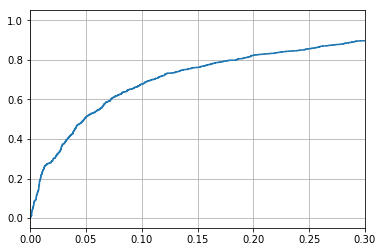

In [80]:
valiTPR_linear = []
valiFPR_linear = []
for i in xrange(1, len(y_validation)):
    tpr, fpr = calculateAUC(validationScoreData_linear[:i], y_validation)
    valiTPR_linear.append(tpr)
    valiFPR_linear.append(fpr)
plt.plot(valiFPR_linear, valiTPR_linear)
plt.xlim(0,0.3)
plt.grid()

In [81]:
# Support vector regression
clf = svm.SVR(C=0.1)
clf.fit(X_train, y_train) 
# trainingScoreData_svr = zip(clf.predict(X_train), y_train)
# trainingScoreData_svr.sort(key = lambda x:x[0], reverse = True)
validationScoreData_svr = zip(clf.predict(X_validation), y_validation)
validationScoreData_svr.sort(key = lambda x:x[0], reverse = True)

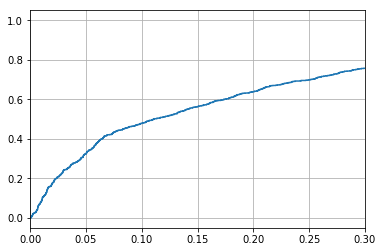

In [82]:
valiTPR_svr = []
valiFPR_svr = []
for i in xrange(1, len(y_validation)):
    tpr, fpr = calculateAUC(validationScoreData_svr[:i], y_validation)
    valiTPR_svr.append(tpr)
    valiFPR_svr.append(fpr)
plt.plot(valiFPR_svr, valiTPR_svr)
plt.xlim(0,0.3)
plt.grid()

In [365]:
# RandomForestRegressor
tree = RandomForestRegressor(n_estimators= 40, max_depth= 8, max_features='log2', bootstrap=True, random_state=0)
tree.fit(X_train_forest, y_train_forest)
# trainingPredict = tree.predict(X_train)
validationPredict = tree.predict(X_validation_forest)

# trainingScoreData_randomforest = zip(tree.predict(X_train_forest), y_train_forest)
# trainingScoreData_randomforest.sort(key = lambda x:x[0], reverse = True)
validationScoreData_randomforest = zip(tree.predict(X_validation_forest), y_validation_forest)
validationScoreData_randomforest.sort(key = lambda x:x[0], reverse = True)

In [368]:
valiTPR_randomforest = []
valiFPR_randomforest = []
for i in xrange(1, len(y_validation_forest)):
    tpr, fpr = calculateAUC(validationScoreData_randomforest[:i], y_validation_forest)
    valiTPR_randomforest.append(tpr)
    valiFPR_randomforest.append(fpr)

NameError: name 'valiFPR_linear' is not defined

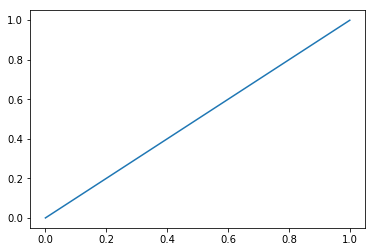

In [74]:
plt.plot([x*0.001 for x in range(0,1000)],[x*0.001 for x in range(0,1000)])
plt.plot(valiFPR_linear, valiTPR_linear)
plt.plot(valiFPR_randomforest, valiTPR_randomforest)
plt.plot(valiFPR_svr, valiTPR_svr)
plt.legend(['baseline', 'linear', 'random forest tree', 'support vector machine'], loc='lower right')
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0,1.0)
plt.ylim(0,1.05)
plt.savefig("AUC.png")

In [77]:
def calculatePrecisionAndRecall(retrievedScore, y):
    precision = len(filter(lambda x: x[1] > 0, retrievedScore)) * 1.0 / len(retrievedScore)
    recall = len(filter(lambda x: x[1] > 0, retrievedScore)) * 1.0 / sum(y)
    return precision, recall

In [78]:
def calculateAUC(retrievedScore, y):
    truePositiveRate = sum([x[1] > 0 for x in retrievedScore]) * 1. / sum(y)
    falsePositiveRate = sum([x[1] == 0 for x in retrievedScore]) * 1. / (len(y)-sum(y))
    return  truePositiveRate, falsePositiveRate

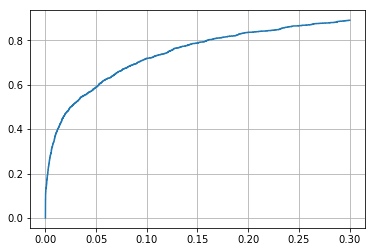

In [111]:
trainPrecisionPath = []
trainRecallPath = []
trainTPR = []
trainFPR = []
for i in xrange(1, 10000):
#     precision, recall = calculatePrecisionAndRecall(trainingScoreData[:i], y_train)
    tpr, fpr = calculateAUC(trainingScoreData[:i], y_train)
#     trainPrecisionPath.append(precision)
#     trainRecallPath.append(recall)
    trainTPR.append(tpr)
    trainFPR.append(fpr)
# plt.plot(trainRecallPath, trainPrecisionPath)
# plt.xlabel("recall")
# plt.ylabel("precision")
plt.plot(trainFPR, trainTPR)
plt.grid()
# plt.savefig("train_PR.png")